In [2]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver

In [1]:
from IPython.display import Image
from selenium.webdriver.common.keys import Keys
import numpy as np
import time

In [3]:
import keras
from keras.layers import Dense, Flatten, Dropout, MaxPooling1D, Conv1D, Input, LSTM, SimpleRNN
from keras.models import Model
from keras.layers.merge import concatenate
from keras.utils import Sequence
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
wd = webdriver.Chrome()

In [4]:
wd.get("https://rinatius.github.io/4magnets/")

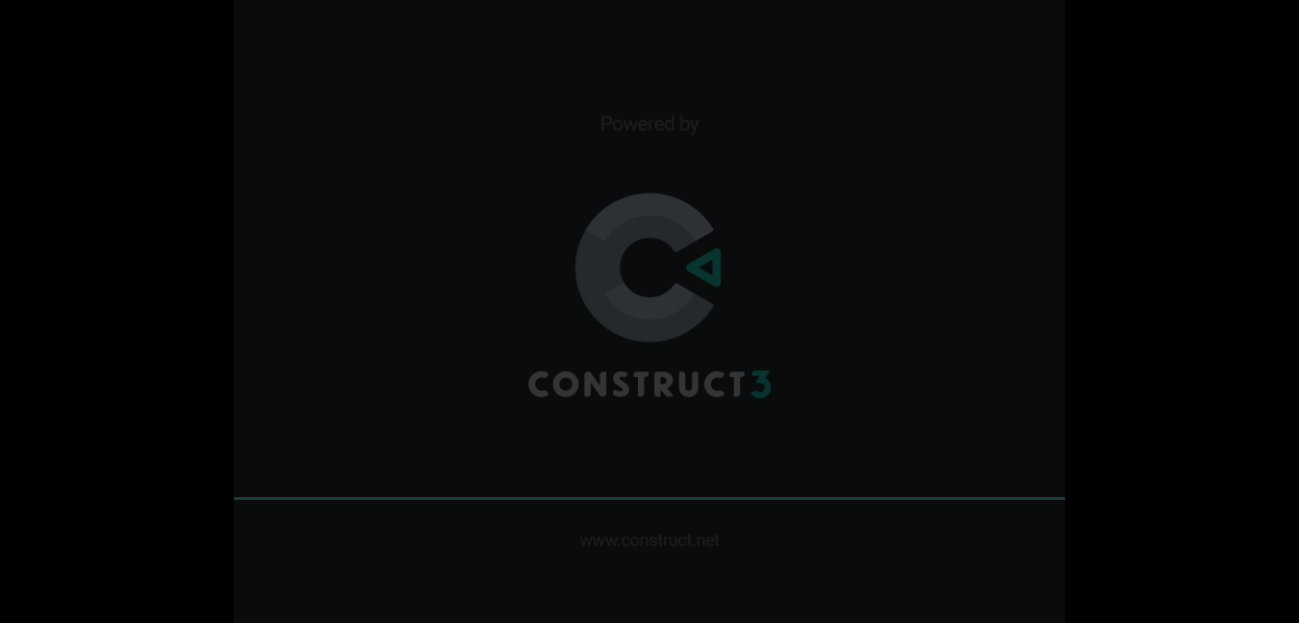

In [5]:
Image(wd.get_screenshot_as_png())

In [6]:
X_MIN = 120
X_MAX = 340
Y_MIN = 56
Y_MAX = 273
multiplier = 100

def write_value(value, element):
    select_all_symbols(element)
    element.send_keys(str(int(value)))

def select_all_symbols(element):
    element.click()
    element.send_keys(Keys.END)
    element.send_keys(Keys.SHIFT + Keys.HOME)

def get_state(wd):
    values = []
    values.append((float(wd.find_element_by_xpath("/html/body/input[2]").get_attribute("value")) - X_MIN)/(X_MAX - X_MIN))
    values.append((float(wd.find_element_by_xpath("/html/body/input[3]").get_attribute("value")) - Y_MIN)/(Y_MAX - Y_MIN))
    values.append((float(wd.find_element_by_xpath("/html/body/input[4]").get_attribute("value")) - X_MIN)/(X_MAX - X_MIN))
    values.append((float(wd.find_element_by_xpath("/html/body/input[5]").get_attribute("value")) - Y_MIN)/(Y_MAX - Y_MIN))
    return np.array(values).reshape(1, len(values))

def act(wd, actions, multiplier=multiplier):
    left = wd.find_element_by_xpath("/html/body/input[1]")
    right = wd.find_element_by_xpath("/html/body/input[6]")
    top = wd.find_element_by_xpath("/html/body/input[7]")
    bottom = wd.find_element_by_xpath("/html/body/input[8]")
    
    write_value(actions[0]*multiplier, left)
    write_value(actions[1]*multiplier, right)
    write_value(actions[2]*multiplier, top)
    write_value(actions[3]*multiplier, bottom)

def randomize_element(wd, x_el, y_el):
    x_element = wd.find_element_by_xpath("/html/body/input["+x_el+"]")
    y_element = wd.find_element_by_xpath("/html/body/input["+y_el+"]")
    x = int(np.random.rand() * (X_MAX - X_MIN) + X_MIN)
    y = int(np.random.rand() * (Y_MAX - Y_MIN) + Y_MIN)
    write_value(x, x_element)
    write_value(y, y_element)

def random_target(wd):
    randomize_element(wd, '2', '3')
    
def random_position(wd):
    randomize_element(wd, '13', '14')
    
def show_prediction(wd, xy):
    x = wd.find_element_by_xpath("/html/body/input[9]")
    y = wd.find_element_by_xpath("/html/body/input[10]")
    
    write_value(int(xy[0] * (X_MAX - X_MIN) + X_MIN), x)
    write_value(int(xy[1] * (Y_MAX - Y_MIN) + Y_MIN), y)
    
def start_sim(wd):
    wd.find_element_by_xpath("/html/body/input[12]").click()
    

In [7]:
state_len = get_state(wd).shape[1]
num_commands = 4
sequence_len = 6
batch_size = 3
batches = 10
epochs = 50
dropout = 0.2
empty = -1
conv_input_shape = (sequence_len, num_commands)

In [8]:
def control_reproduction_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

'''def prediction_loss(y_true, y_pred):
    prediction_accuracy = K.mean(K.sum(K.square(y_pred - y_true[:, 3])))
    square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))
    combined_loss = K.exp(prediction_accuracy)*square_distance_to_target
    return combined_loss'''

def prediction_loss(y_true, y_pred):
    prediction_accuracy = K.mean(K.sum(K.square(y_pred - y_true[:, 3, :])))
    #square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))
    combined_loss = prediction_accuracy
    return combined_loss

def prediction_accuracy(y_true, y_pred):
    return K.mean(K.sum(K.square(y_pred - y_true[:, 3, :])))

def distance_to_target(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true[:, 0] - y_true[:, 3, :])))

def predicted_distance_to_target(y_true, y_pred):
    return K.mean(K.sum(K.square(y_pred - y_true[:, 0, :])))

def prediction_reproduction(y_true, y_pred):
    return K.mean(K.sum(K.square(y_pred - y_true[:, 4, :])))

'''def prediction_loss(y_true, y_pred):
    prediction_accuracy = K.mean(K.sum(K.square(y_pred)))
    #square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))
    combined_loss = prediction_accuracy
    return combined_loss'''

'def prediction_loss(y_true, y_pred):\n    prediction_accuracy = K.mean(K.sum(K.square(y_pred)))\n    #square_distance_to_target = K.mean(K.sum(K.square(y_pred - y_true[:, 0])))\n    combined_loss = prediction_accuracy\n    return combined_loss'

In [10]:
class WDSequence(Sequence):

    def __init__(self,
                 wd,
                 model,
                 batches,
                 batch_size):
        self.model = model
        self.wd = wd
        self.batches = batches
        self.batch_size = batch_size        

    def __len__(self):
        return self.batches

    def __getitem__(self, idx):
        
        self.wd.get("https://rinatius.github.io/4magnets/")
        time.sleep(7)
        random_target(self.wd)
        random_position(self.wd)
        start_sim(self.wd)
        state = np.full([sequence_len, state_len], empty)
        
        in_state = []
        out_control = []
        out_prediction = []
        
        for i in range(batch_size):  

            state = np.append(state[1:], get_state(wd), axis=0)


            target = state[-1, :2]
            position = state[-1, 2:]


            y_pred = self.model.predict(state.reshape([1, state.shape[0], state.shape[1]]))
            actions = y_pred[0][0][0]

            act(wd, actions)
            show_prediction(wd, y_pred[1][0][0])
            time.sleep(0.3)

            new_state = get_state(wd)
            new_target = new_state[0][:2]
            new_position = new_state[0][2:]

            predicted_position = y_pred[1][0][0]

            in_state.append(state)
            out_control.append(y_pred[0][0])
            out_prediction.append([target, position, new_target, new_position, predicted_position])
            #out_prediction.append(new_position)
        
        return ({'in_state': np.array(in_state)}, 
                {'out_control': np.array(out_control), 
                 'out_prediction': np.array(out_prediction)} )

In [11]:
#input_shape = [1, 8]

#in_state = LSTM(4, input_shape=(None, 1, 4), return_sequences=True, name='in_state')
in_state = Input(shape=(None, 4), name='in_state')
first_lstm = LSTM(128, return_sequences=True, name='first_lstm')(in_state)
l = LSTM(128)(first_lstm)
l = Dense(128, activation='relu')(l)
out_control = Dense(num_commands, activation='sigmoid', name='out_control')(l)
last_lstm = LSTM(128, name='last_lstm')(first_lstm)
l = concatenate([last_lstm, out_control])
l = Dense(128, activation='relu')(l)
out_prediction = Dense(2, activation='sigmoid', name='out_prediction')(l)

In [12]:
in_state = Input(shape=conv_input_shape, name='in_state')
first_seq = Conv1D(128, kernel_size=2, activation='relu', name='first_seq')(in_state)
l = Conv1D(128, kernel_size=2, activation='relu')(first_seq)
l = MaxPooling1D(pool_size=2)(l)
l = Conv1D(128, kernel_size=2, activation='relu')(l)
#l = Flatten()(l)
l = Dense(128, activation='relu')(l)
out_control = Dense(num_commands, activation='sigmoid', name='out_control')(l)
l = Conv1D(128, kernel_size=2, activation='relu')(in_state)
l = MaxPooling1D(pool_size=2)(l)
l = Conv1D(128, kernel_size=2, activation='relu')(l)
#l = Flatten()(l)
l = concatenate([l, out_control])
l = Dense(128, activation='relu')(l)
l = Dense(128, activation='relu')(l)
out_prediction = Dense(2, activation='sigmoid', name='out_prediction')(l)

In [13]:
model = Model(inputs=[in_state],
              outputs=[out_control, out_prediction])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_state (InputLayer)           (None, 6, 4)         0                                            
__________________________________________________________________________________________________
first_seq (Conv1D)              (None, 5, 128)       1152        in_state[0][0]                   
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4, 128)       32896       first_seq[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 2, 128)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (

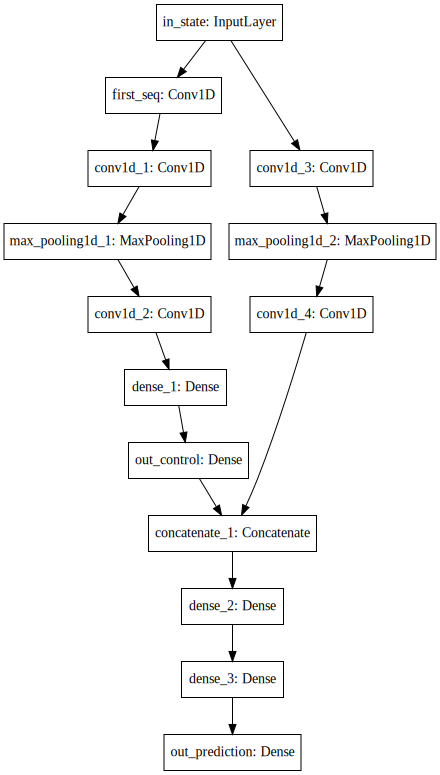

In [14]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
model.compile(loss={'out_control': control_reproduction_loss,
                    'out_prediction': prediction_loss},
              loss_weights={'out_control': 0,
                            'out_prediction': 1},
              optimizer=keras.optimizers.Adam(),
              metrics={'out_prediction': [prediction_accuracy,
                                          distance_to_target, 
                                          predicted_distance_to_target,
                                          prediction_reproduction]})

In [16]:
#model.load_weights('2steps_dense.h5')

In [17]:
sequence = WDSequence(wd, model, batches=batches, batch_size=batch_size)

In [18]:
state = np.full([sequence_len, num_commands], empty)
state = np.append(state[1:], get_state(wd), axis=0)
model.predict(state.reshape(1, state.shape[0], state.shape[1]))[1][0][0]

array([0.51413953, 0.47580415], dtype=float32)

In [19]:
model.fit_generator(sequence, epochs=epochs, verbose=1)

Epoch 1/50
10/10 [==============================] - 113s 11s/step - loss: 2.1248 - out_control_loss: 3.1086e-16 - out_prediction_loss: 2.1248 - out_prediction_prediction_accuracy: 2.1248 - out_prediction_distance_to_target: 0.7615 - out_prediction_predicted_distance_to_target: 1.3547 - out_prediction_prediction_reproduction: 0.0024
Epoch 2/50
10/10 [==============================] - 111s 11s/step - loss: 1.5389 - out_control_loss: 5.1070e-16 - out_prediction_loss: 1.5389 - out_prediction_prediction_accuracy: 1.5389 - out_prediction_distance_to_target: 1.4854 - out_prediction_predicted_distance_to_target: 1.6661 - out_prediction_prediction_reproduction: 0.0049
Epoch 3/50
10/10 [==============================] - 112s 11s/step - loss: 1.7697 - out_control_loss: 4.2929e-16 - out_prediction_loss: 1.7697 - out_prediction_prediction_accuracy: 1.7697 - out_prediction_distance_to_target: 1.6128 - out_prediction_predicted_distance_to_target: 2.2709 - out_prediction_prediction_reproduction: 0.004

KeyboardInterrupt: 

In [20]:
#model.save_weights('conv1D_dense_38epochs.h5')

In [ ]:
model.predict(np.array([get_state(wd)]))[1][0][0]

In [ ]:
[get_state(wd)].shape

In [ ]:
test = np.random.rand(3, 5, 2)

In [ ]:
test

In [ ]:
test[:, 3, :]

In [ ]:
test.reshape([3, 1, 5])[:, :, 0]

In [ ]:
in_state = []
state = get_state(wd)

In [ ]:
state

In [ ]:
in_state.append(state)

In [ ]:
in_state

In [ ]:
np.array(in_state)

In [ ]:
state1 = get_state(wd)

In [ ]:
state2 = get_state(wd)

In [ ]:
np.append(state1, state2).reshape([1, 8])

In [ ]:
state1.shape

In [ ]:
model.predict(get_state(wd).reshape([1, 1, 4]))[0]

In [ ]:
s = get_state(wd)

In [ ]:
state_h = get_state(wd)

In [ ]:
state_h = np.append(state_h, s, axis=0)

In [ ]:
model.predict(state_h.reshape([1, state_h.shape[0], state_h.shape[1]]))[0][0].shape

In [ ]:
state_h

In [ ]:
form = np.full([sequence_len, state_len], empty)

In [ ]:
form

In [ ]:
form = np.append(form[1:], get_state(wd), axis=0)

In [ ]:
form

In [ ]:
form = np.append(form[1:], get_state(wd),  axis=0)

In [ ]:
model.predict(form.reshape([1, form.shape[0], form.shape[1]]))

In [ ]:
get_state(wd)[0][2:]

In [ ]:
form

In [ ]:
form[-1, 2:]

In [9]:
np.full([sequence_len, state_len], get_state(wd))

array([[ 0.39545455,  0.59907834, -0.5       , -0.21198157],
       [ 0.39545455,  0.59907834, -0.5       , -0.21198157],
       [ 0.39545455,  0.59907834, -0.5       , -0.21198157],
       [ 0.39545455,  0.59907834, -0.5       , -0.21198157],
       [ 0.39545455,  0.59907834, -0.5       , -0.21198157],
       [ 0.39545455,  0.59907834, -0.5       , -0.21198157]])